In [1]:
! wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

URL transformed to HTTPS due to an HSTS policy
--2019-01-25 09:24:24--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip.1’

trainingandtestdata 100%[===================>]  77.59M  2.75MB/s    in 76s     

2019-01-25 09:25:41 (1.01 MB/s) - ‘trainingandtestdata.zip.1’ saved [81363704/81363704]



In [2]:
! unzip trainingandtestdata.zip

Archive:  trainingandtestdata.zip
replace testdata.manual.2009.06.14.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:
! head training.1600000.processed.noemoticon.csv -n 3

"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"
"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"
"0","1467810917","Mon Apr 06 22:19:53 PDT 2009","NO_QUERY","mattycus","@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds"


In [4]:
! head testdata.manual.2009.06.14.csv -n 3

"4","3","Mon May 11 03:17:40 UTC 2009","kindle2","tpryan","@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
"4","4","Mon May 11 03:18:03 UTC 2009","kindle2","vcu451","Reading my kindle2...  Love it... Lee childs is good read."
"4","5","Mon May 11 03:18:54 UTC 2009","kindle2","chadfu","Ok, first assesment of the #kindle2 ...it fucking rocks!!!"


In [5]:
import pandas as pd

In [6]:
df_train = pd.read_csv("training.1600000.processed.noemoticon.csv", header=None, error_bad_lines=False, encoding='latin1')
df_test = pd.read_csv("testdata.manual.2009.06.14.csv", header=None, error_bad_lines=False, encoding="latin1")
df_train = df_train[[0, 5]]
df_test = df_test[[0, 5]]
df_train.columns = ["label", "text"]
df_test.columns = ["label", "text"]

In [7]:
df_test = df_test[df_test["label"] != 2]
df_train["label"] = df_train["label"] == 0
df_test["label"] = df_test["label"] == 0

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

df_test = shuffle(df_test)
df_train = shuffle(df_train)

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    df_train, df_train["label"], num_epochs=None, shuffle=True)

predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    df_test, df_test["label"], shuffle=False)

embedded_text_feature_column = hub.text_embedding_column(
        key="text",
        module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

estimator = tf.estimator.DNNClassifier(
        hidden_units=[500, 100],
        feature_columns=[embedded_text_feature_column],
        n_classes=2,
        optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

estimator.train(input_fn=train_input_fn, steps=1000);
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)
print("Test set accuracy: {accuracy}".format(**test_eval_result))

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpj0mau167', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f27afd9f048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpj0mau167/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


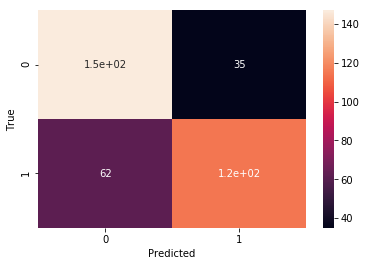

In [9]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    0, 1
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
    cm = tf.confusion_matrix(
        df_test["label"], 
        get_predictions(estimator, predict_test_input_fn))
    with tf.Session() as session:
        cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
# cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");